# LGBM model Spaceship Titanic kaggle

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna

from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, f1_score, accuracy_score

In [2]:
# импорт данных
df_sam = pd.read_csv('sample_submission.csv')
df = pd.read_csv('train.csv')
df_pred = pd.read_csv('test.csv')
df_pred_PassengerId = df_pred['PassengerId']

## Знакомство с данными

In [3]:
print("\033[1m" + "\033[30m" + 'nan значения в основной таблице:' + "\033[0m")
print(df.isna().sum())
print('-------------------')
print("\033[1m" + "\033[30m" + 'nan значения в таблице для предсказания:' + "\033[0m")
print(df_pred.isna().sum())

nan значения в основной таблице:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
-------------------
nan значения в таблице для предсказания:
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


In [4]:
print("\033[1m" + "\033[30m" + 'Типы данных  в основной таблице:' + "\033[0m")
print(df.dtypes)
print('-----------------------')
print("\033[1m" + "\033[30m" + 'Типы данных в таблице для предсказания:' + "\033[0m")
print(df_pred.dtypes)

Типы данных  в основной таблице:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object
-----------------------
Типы данных в таблице для предсказания:
PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
dtype: object


In [5]:
print("\033[1m" + "\033[30m" + 'Статистика для основных данных:' + "\033[0m")
print(df.describe())
print('-' * 74)
print("\033[1m" + "\033[30m" + 'Статистика для предсказательных данных:' + "\033[0m")
print(df_pred.describe())

Статистика для основных данных:
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   8512.000000   8510.000000   8485.000000   8510.000000   
mean     28.827930    224.687617    458.077203    173.729169    311.138778   
std      14.489021    666.717663   1611.489240    604.696458   1136.705535   
min       0.000000      0.000000      0.000000      0.000000      0.000000   
25%      19.000000      0.000000      0.000000      0.000000      0.000000   
50%      27.000000      0.000000      0.000000      0.000000      0.000000   
75%      38.000000     47.000000     76.000000     27.000000     59.000000   
max      79.000000  14327.000000  29813.000000  23492.000000  22408.000000   

             VRDeck  
count   8505.000000  
mean     304.854791  
std     1145.717189  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%       46.000000  
max    24133.000000  
-------------------------------------------------------------------

## Подготовка данных

### PassengerId
- Создаю два столбца 'Group' и 'Number' из столбца 'PassengerId' по разделителю '_', привожу к типу int.
- Удаляю PassengerId.
- Все действия буду проводить с обоими датасетами сразу.

In [6]:
df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype('int')
df['Number'] = df['PassengerId'].apply(lambda x: x.split('_')[1]).astype('category')
df = df.drop('PassengerId', axis=1)

df_pred['Group'] = df_pred['PassengerId'].apply(lambda x: x.split('_')[0]).astype('int')
df_pred['Number'] = df_pred['PassengerId'].apply(lambda x: x.split('_')[1]).astype('category')
df_pred = df_pred.drop('PassengerId', axis=1)

### Transported
- Привожу к числовому типу целевую переменную.

In [7]:
df.Transported.value_counts()  # Целевая переменная сбалансирована.

Transported
True     4378
False    4315
Name: count, dtype: int64

In [8]:
# целевой признак в числовой вид
df.replace({'Transported': {False: 0, True: 1}}, inplace=True)

### 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
- NaN значения заменяю на 0.0
- Создаю новый признак с суммой всех этих столбцов 

In [9]:
df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0.0)
df['TotalServices'] = df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

df_pred[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df_pred[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0.0)
df_pred['TotalServices'] = df_pred[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].sum(axis=1)

### CryoSleep, HomePlanet, VIP
- Заменяю NaN на mode
- Преобразую в числовой формат.

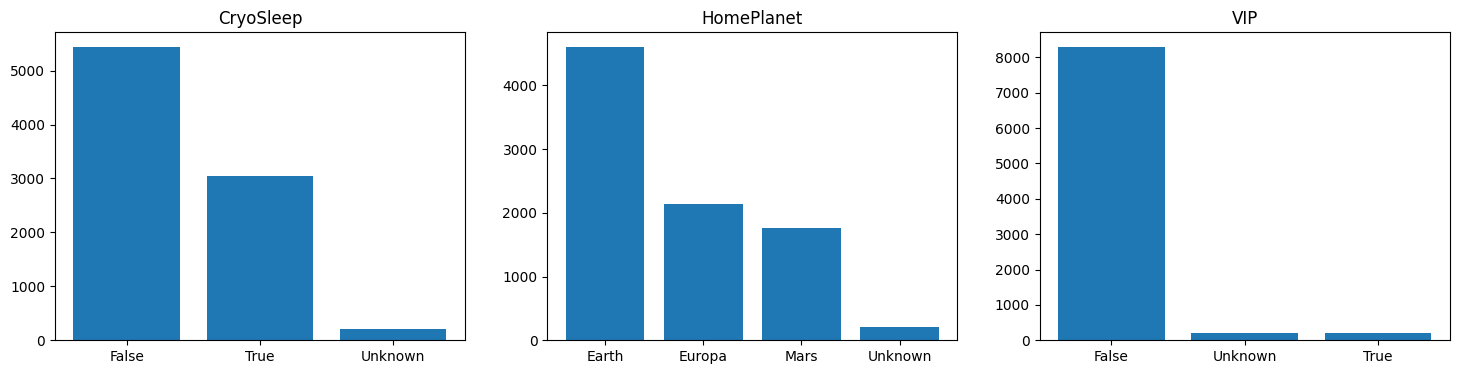

In [10]:
# Задаем размеры графиков
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18, 4))

# Строим первый график
CryoSleep_ = df['CryoSleep'].fillna('Unknown').value_counts()
ax1.bar(CryoSleep_.index.astype(str), CryoSleep_.values)  # Преобразуем индексы в строки здесь
ax1.set_title('CryoSleep')

# Строим второй график
HomePlanet_ = df['HomePlanet'].fillna('Unknown').value_counts()
ax2.bar(HomePlanet_.index.astype(str), HomePlanet_.values)  # Преобразуем индексы в строки здесь
ax2.set_title('HomePlanet')

# Строим третий график
VIP_ = df['VIP'].fillna('Unknown').value_counts()
ax3.bar(VIP_.index.astype(str), VIP_.values)  # Преобразуем индексы в строки здесь
ax3.set_title('VIP')

# Отображаем графики
plt.show()

In [11]:
columns_to = ['CryoSleep', 'HomePlanet', 'VIP']
for i in columns_to:
    df[i] = df[i].fillna(df[i].mode()[0]).astype('category')
    df_pred[i] = df_pred[i].fillna(df[i].mode()[0]).astype('category')

## Cabin
- Создаю три столба из Cabin: Deck, Num, Side.
- Удаляю Cabin.

In [12]:
df['Deck'] = df['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
df['Num'] = df['Cabin'].apply(lambda x: x.split('/')[1] if isinstance(x, str) else x)
df['Side'] = df['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else x)
df.drop(columns='Cabin', inplace=True)

df_pred['Deck'] = df_pred['Cabin'].apply(lambda x: x.split('/')[0] if isinstance(x, str) else x)
df_pred['Num'] = df_pred['Cabin'].apply(lambda x: x.split('/')[1] if isinstance(x, str) else x)
df_pred['Side'] = df_pred['Cabin'].apply(lambda x: x.split('/')[2] if isinstance(x, str) else x)
df_pred.drop(columns='Cabin', inplace=True)

In [13]:
df['Deck'] = df.Deck.fillna(df.Deck.mode()[0]).astype('category')
df['Num'] = df.Num.ffill().astype('int')
df['Side'] = df.Side.fillna(df.Side.mode()[0]).astype('category')

df_pred['Deck'] = df_pred.Deck.fillna(df_pred.Deck.mode()[0]).astype('category')
df_pred['Num'] = df_pred.Num.ffill().astype('int')
df_pred['Side'] = df_pred.Side.fillna(df_pred.Side.mode()[0]).astype('category')

## Destination
- Nan заменяю на моду

In [14]:
df['Destination'] = df.Destination.fillna(df.Destination.mode()[0]).astype('category')
df_pred['Destination'] = df_pred.Destination.fillna(df_pred.Destination.mode()[0]).astype('category')

## Age
- Nan значение заменяю на сред. значение.
- Есть значения с 0

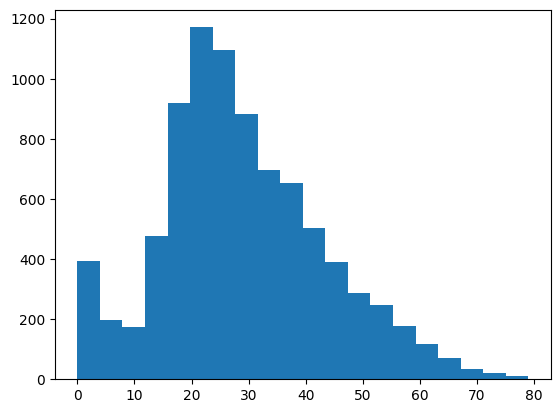

In [15]:
# создаем график
plt.hist(df['Age'], bins=20)

plt.show()

In [16]:
df.Age.fillna(df.Age.mean(), inplace=True)
df_pred.Age.fillna(df.Age.mean(), inplace=True)

## Name
- Удаляю
- Нужно придумать как из имен сделать признак с полом

In [17]:
df.drop(columns='Name', inplace=True)
df_pred.drop(columns='Name', inplace=True)

## HasServices
- Создаем признак (были ли вообще траты)

In [18]:
df['HasServices'] = (df['TotalServices'] > 0).astype('category')
df_pred['HasServices'] = (df_pred['TotalServices'] > 0).astype('category')

## Модель

In [19]:
X = df.drop(columns='Transported')
y = df['Transported']

In [20]:
lst = []
for i in X.columns:
    if df[i].dtypes == 'category':
        lst.append(i)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# def objective(trial: optuna.Trial):
#     '''
#     Обычная сигнатура функции оптимизации для optuna.
#     '''
#     param = {
#             "verbosity": -1,
#             "boosting_type": "gbdt",
#             "random_state": 42,
#             "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
#             "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
#             'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
#             'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
#             "max_depth": trial.suggest_int("max_depth", 5, 25),
#             "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
#             "subsample": trial.suggest_float("subsample", 0.8, 1.0),
#             "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
#             'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
#             'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0)}
    
#     lgbm_model = LGBMClassifier(**param)
#     lgbm_model.fit(X_train, y_train)
#     y_pred = lgbm_model.predict(X_test)
#     return accuracy_score(y_test, y_pred)

In [23]:
# %%time
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200)

In [24]:
best_params = {
     "verbosity": -1,
     "boosting_type": "gbdt",
     "random_state": 42,
     'learning_rate': 0.030018077829513434,
     'n_estimators': 802,
     'lambda_l1': 3.0098282141559296,
     'lambda_l2': 4.011035680904194e-08,
     'max_depth': 11,
     'colsample_bytree': 0.5717499737816155,
     'subsample': 0.8885252066982045,
     'min_child_samples': 21,
     'feature_fraction': 0.6090781828286976,
     'bagging_fraction': 0.6518437070058158
}

In [25]:
lgbm_model = LGBMClassifier(**best_params)
lgbm_model.fit(X_train, y_train)
y_pred = lgbm_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.8154111558366878

In [26]:
#lgbm_model.fit(X, y)
pred = lgbm_model.predict(df_pred)

Text(0.5, 0, 'CatBoost Feature Importance')

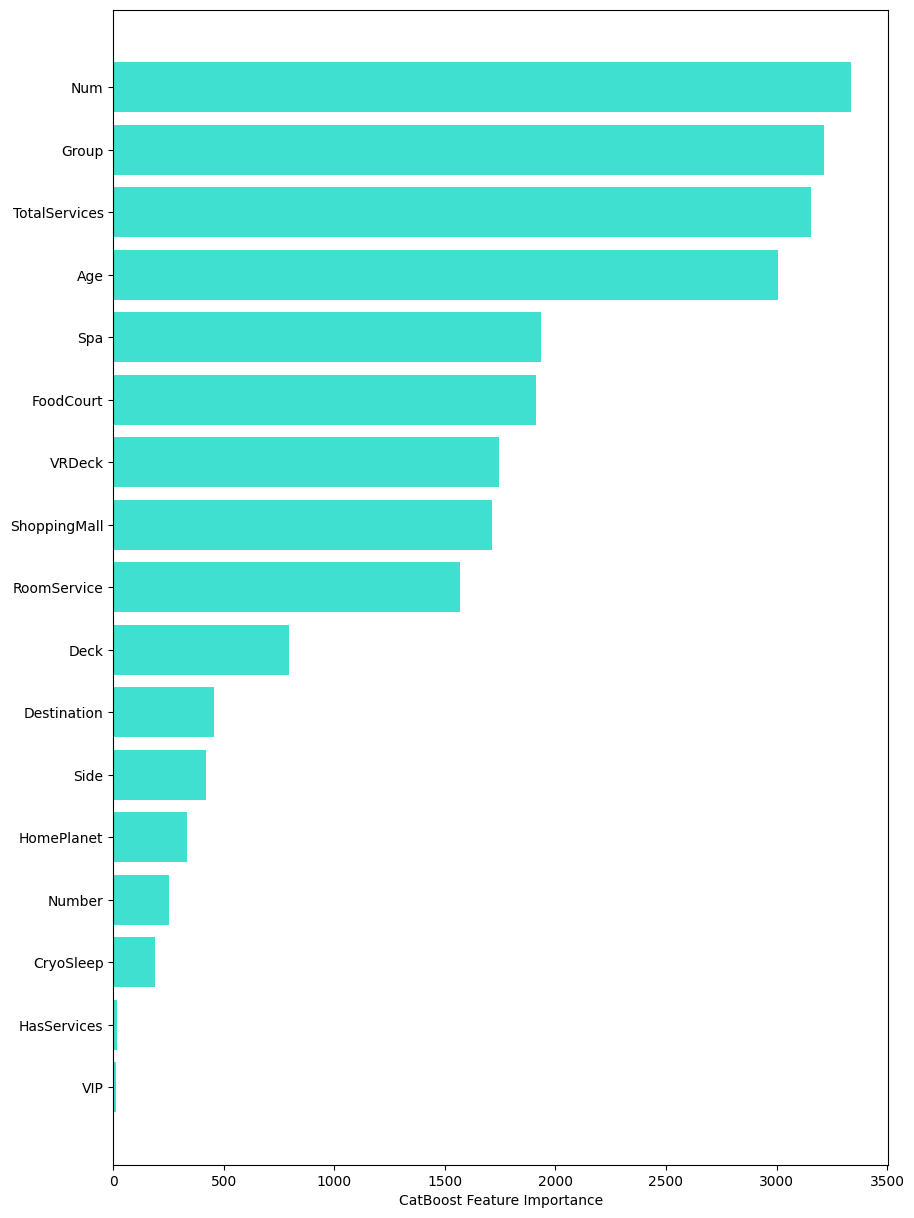

In [27]:
# кареляция каждого столбца
sorted_feature_importance = lgbm_model.feature_importances_.argsort()
plt.figure(figsize=(10, 15))
plt.barh(X.columns[sorted_feature_importance], 
        lgbm_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [28]:
# Создаю фрейм данных для хранения названий объектов и их важности
feature_importance_df = pd.DataFrame({
    'Feature': X.columns[sorted_feature_importance],
    'Importance': lgbm_model.feature_importances_[sorted_feature_importance]
})

# сортирую фрейм данных по важности в порядке убывания
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)

          Feature  Importance
16            Num        3339
15          Group        3216
14  TotalServices        3155
13            Age        3007
12            Spa        1933
11      FoodCourt        1910
10         VRDeck        1746
9    ShoppingMall        1715
8     RoomService        1567
7            Deck         795
6     Destination         454
5            Side         420
4      HomePlanet         333
3          Number         250
2       CryoSleep         189
1     HasServices          16
0             VIP          11


## При удалении HasServices, VIP результат хуже

In [36]:
output = pd.DataFrame({'PassengerId': df_pred_PassengerId, 'Transported': pred})
output['Transported'] = output['Transported'].astype(bool)
output.to_csv('submission_lgbm.csv', index=False)

# kaggel Score: 0.80406